In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [26]:
df = pd.read_csv('data/Seasons_Stats.csv')
print(df.shape)

(24691, 53)


## Clean Data

In [27]:
def filter_years(df):
    # Filter data so only seasons from 2010 onwards are included
    df = df[df['Year'].notna()]
    df = df[df['Year'] >= 2003]
    df['Year'] = df['Year'].astype(int)
    return df

def cleaned_df(df):
    # Clean dataframe so only 1 season stat is included for every player per season
    years = df['Year'].unique()
    for year in years:
        df_year = df[df['Year'] == year]
        df_year = df_year[df_year.duplicated(subset='Player', keep=False)]
        common_rows = df['Unnamed: 0'].isin(df_year['Unnamed: 0'])
        df.drop(df[common_rows].index, inplace = True)
        df = df.append(df_year[df_year['Tm'] == 'TOT'])
    return df

def fill_empty_values(df):
    # Remove unneccesary columns and fill nulls with 0
    df.drop(columns=['Unnamed: 0', 'blanl', 'blank2'], inplace=True)
    df.drop(df[df['USG%'].isnull()].index, inplace=True)
    df.fillna(0, inplace=True)
    return df

In [28]:
df = filter_years(df)
df = cleaned_df(df)
df = fill_empty_values(df)
df.shape

(6913, 50)

In [23]:
# Taking only first position listed when multiple are listed
df['Pos'] = df['Pos'].str.split('-').str[0]

Visualize

In [6]:
features = [x for x in df.columns if (x != 'Player') &  (x != 'Pos')]
print(df.shape)
print(features)

(3771, 50)
['Year', 'Age', 'Tm', 'G', 'GS', 'MP', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']


In [7]:
def df_PCA_yr(df, year):
    df_vis = df[df['Year'] == year]
    df_vis = df_vis.drop('Year', axis=1)
    features = [x for x in df_vis.columns if (x != 'Player') &  (x != 'Pos') & (x != 'Tm')]
    x = df_vis.loc[:, features].values
    y = df_vis.loc[:,['Pos']].values
    x = StandardScaler().fit_transform(x)
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(x)
    principalDf = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2'])
    final = pd.concat([principalDf.reset_index(drop=True), df_vis['Pos'].reset_index(drop=True)], axis=1)
    print("Explained variance: ", pca.explained_variance_ratio_)
    return final,pca,features

def plot_PCA(df_PCA):
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('2 component PCA', fontsize = 20)

    targets = df_PCA.Pos.unique() # list of positions (PCA groups)
    colors = ['r', 'g', 'b', 'm', 'c']
    for target, color in zip(targets,colors):
        indicesToKeep = df_PCA['Pos'] == target
        ax.scatter(df_PCA.loc[indicesToKeep, 'pc1']
                , df_PCA.loc[indicesToKeep, 'pc2']
                , c = color
                , s = 50)
    ax.legend(targets)
    ax.grid()
    return None

def plot_featImport_PCA(pcaObj, features):
     # feature importance for first dimension
    fimp1 = pd.DataFrame(data={'feat':features,'imp':pcaObj.components_[0]})
    fimp1 = fimp1.reindex(fimp1.imp.abs().sort_values(ascending = False).index)
    # print(fimp1)
    top_fimp1 = fimp1.nlargest(10,'imp')
    top_fimp1 = top_fimp1.iloc[::-1]
    top_fimp1 = top_fimp1.set_index("feat")
    ax = top_fimp1.plot.barh()
    ax.set_xlabel('Importance', fontsize = 15)
    ax.set_ylabel('Feature', fontsize = 15)
    ax.set_title('PCA Component 1 Feature Importance', fontsize = 20)

    # repeat for second dimension
    fimp2 = pd.DataFrame(data={'feat':features,'imp':pcaObj.components_[1]})
    fimp2 = fimp2.reindex(fimp2.imp.abs().sort_values(ascending = False).index)
    top_fimp2 = fimp2.nlargest(10,'imp')
    top_fimp2 = top_fimp2.iloc[::-1]
    top_fimp2 = top_fimp2.set_index("feat")
    ax = top_fimp2.plot.barh()
    ax.set_xlabel('Importance', fontsize = 15)
    ax.set_ylabel('Feature', fontsize = 15)
    ax.set_title('PCA Component 2 Feature Importance', fontsize = 20)

Explained variance:  [0.43195393 0.16785902]


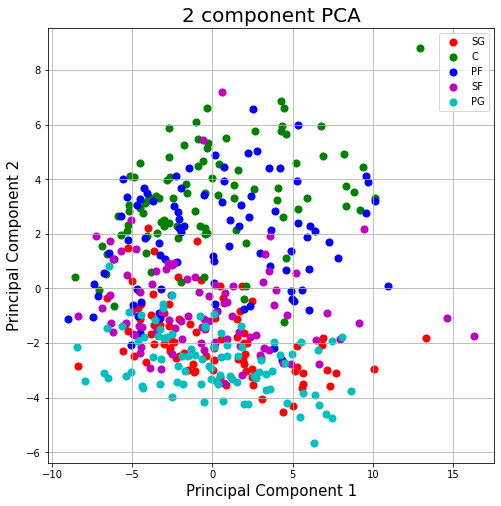

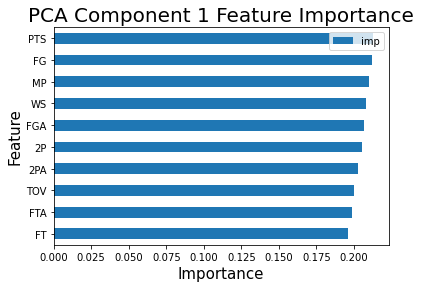

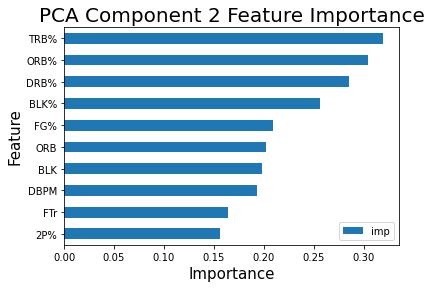

In [8]:
df_PCA, pca, features = df_PCA_yr(df, 2010)
plot_PCA(df_PCA)
plot_featImport_PCA(pca, features)

# K-Means Clustering

### Note: You may need to re-run the second block of code (reading the .csv) AND the data cleaning block before running everything after this point.

In [9]:
year = 2010
print(df.columns)

season_data = df[df['Year'] == year]
season_data = season_data.drop('Year', axis=1)
season_data.mean()
season_data.loc[:,"FG"].mean()

Index(['Year', 'Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'PER', 'TS%',
       '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%',
       'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP',
       'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%',
       'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV',
       'PF', 'PTS'],
      dtype='object')


210.2721088435374

### Create a pairplot and a heatmap in order to see correlations between different columns

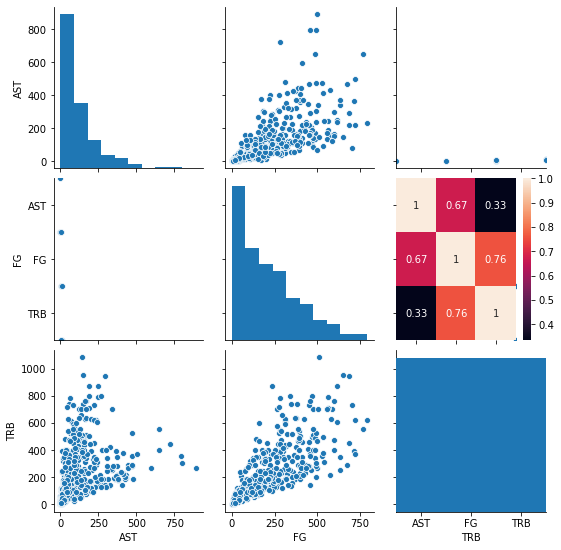

In [10]:
correlation = season_data[["AST", "FG", "TRB"]].corr()
sns.pairplot(season_data[["AST", "FG", "TRB"]])
sns.heatmap(correlation, annot=True)

### Use the K-Means Clustering Method to see which players are the most similar

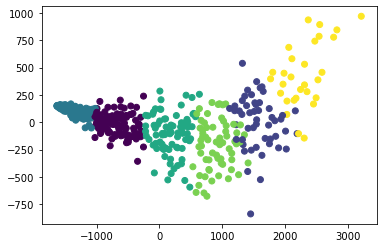

In [11]:
model = KMeans(n_clusters=6, random_state=1)
columns_with_data = season_data._get_numeric_data().dropna(axis=1)
model.fit(columns_with_data)
data_labels = model.labels_

nba_pca = PCA(2)
plot_columns = nba_pca.fit_transform(columns_with_data)
plt.scatter(x=plot_columns[:,0], y=plot_columns[:,1], c=data_labels)

### How to see which cluster a specific player belongs to

In [12]:
player_one = columns_with_data.loc[season_data['Player'] == 'Stephen Curry',:]
player_two = columns_with_data.loc[season_data['Player'] == 'Kyle Lowry',:]

player_one_list = player_one.values.tolist()
player_two_list = player_two.values.tolist()

player_one_label = model.predict(player_one_list)
player_two_label = model.predict(player_two_list)

print(player_one_label)
print(player_two_label)

[1]
[3]


### Split data into 80% training and 20% testing for the columns you want to use. The first column is the data you will be using to predict the value of the second column

# Spectral Clustering

In [15]:
def season_data(df, year):
    season_data = df[df['Year'] == year]
    season_data = season_data.drop('Year', axis=1)
    return season_data

def season_numeric_data(season_df):
    return season_df._get_numeric_data().dropna(axis=1)

def generate_spec_model(k):
    spec = SpectralClustering(n_clusters=k, affinity='nearest_neighbors',assign_labels='kmeans')
    return spec

def __get_PCA_with_clusters(season_numeric):
    nba_pca = PCA(2) #put data into 2 dimensions
    return nba_pca.fit_transform(season_numeric)

def get_labels(model, season_numeric):
    labels = model.fit_predict(season_numeric)
    return labels

def plot_PCA_with_clusters(labels, season_numeric):
    plot_columns = __get_PCA_with_clusters(season_numeric)   
    plt.scatter(x=plot_columns[:,0], y=plot_columns[:,1], c=labels)
    plt.xlabel('PC1', fontsize=15)
    plt.xticks(fontsize=12)
    plt.ylabel('PC2', fontsize=15)
    plt.yticks(fontsize=12)
    plt.title('Data plotted into Clusters', fontsize=16)
    plt.show()

def plot_Silh_Score(season_numeric, min_cluster, max_cluster):
    silhouette_scores = []
    for i in range(min_cluster, max_cluster):
        model = generate_spec_model(i)
        labels = get_labels(model, season_numeric)
        silhouette_avg = silhouette_score(season_numeric, labels)
        silhouette_scores.append(silhouette_avg)
        print("For n_clusters =", i, "The average silhouette_score is:", silhouette_avg)
        
    n_clusters = list(range(min_cluster, max_cluster))
    plt.plot(n_clusters, silhouette_scores, '-o')
    plt.grid()
    plt.xlabel('Number of Clusters', fontsize=15)
    plt.xticks(fontsize=12)
    plt.ylabel('Score', fontsize=15)
    plt.yticks(fontsize=12)
    plt.title('Silhouette Scores', fontsize=16)
    plt.show()

# TODO Needs to be changed for Spectral Clustering (if we plan on using this part of it at least)
def get_player_label(model, season_df, season_numeric, player_name):
    player = season_numeric.loc[season_df['Player'] == player_name,:]
    player_list = player.values.tolist()
    player_label = model.predict(player_list)
    return player_label

2002
For n_clusters = 2 The average silhouette_score is: 0.36754931119381923
For n_clusters = 3 The average silhouette_score is: 0.4118830882556517
For n_clusters = 4 The average silhouette_score is: 0.31913263034190203
For n_clusters = 5 The average silhouette_score is: 0.35364945910818707
For n_clusters = 6 The average silhouette_score is: 0.33262029248418956
For n_clusters = 7 The average silhouette_score is: 0.3251473881108252
For n_clusters = 8 The average silhouette_score is: 0.29976120128124184
For n_clusters = 9 The average silhouette_score is: 0.2820436693475642
For n_clusters = 10 The average silhouette_score is: 0.25560369052387466


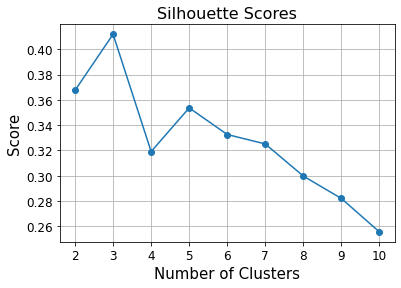

2003
For n_clusters = 2 The average silhouette_score is: 0.34002371070653664
For n_clusters = 3 The average silhouette_score is: 0.4057843174125128
For n_clusters = 4 The average silhouette_score is: 0.3794594477686355
For n_clusters = 5 The average silhouette_score is: 0.4031755135547073
For n_clusters = 6 The average silhouette_score is: 0.33527368095417454
For n_clusters = 7 The average silhouette_score is: 0.3320033921610358
For n_clusters = 8 The average silhouette_score is: 0.3297808769710113
For n_clusters = 9 The average silhouette_score is: 0.311254308626169
For n_clusters = 10 The average silhouette_score is: 0.30184672346086144


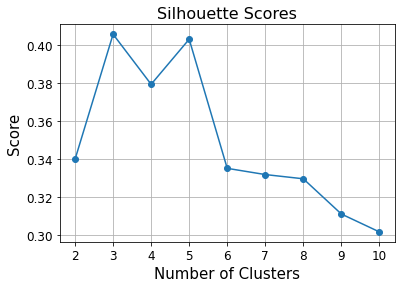

2004
For n_clusters = 2 The average silhouette_score is: 0.34964950020340746
For n_clusters = 3 The average silhouette_score is: 0.4045468133618061
For n_clusters = 4 The average silhouette_score is: 0.38073863139859837
For n_clusters = 5 The average silhouette_score is: 0.35421994346262
For n_clusters = 6 The average silhouette_score is: 0.342722523355426
For n_clusters = 7 The average silhouette_score is: 0.3327645711542187
For n_clusters = 8 The average silhouette_score is: 0.31937830184337296
For n_clusters = 9 The average silhouette_score is: 0.2939363241957891
For n_clusters = 10 The average silhouette_score is: 0.27949087098677233


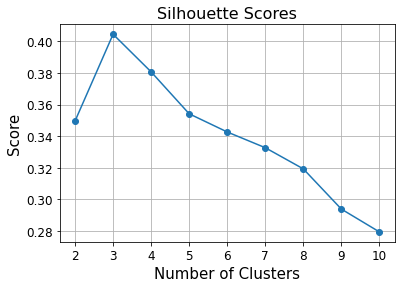

2005
For n_clusters = 2 The average silhouette_score is: 0.43920854595323927
For n_clusters = 3 The average silhouette_score is: 0.35705529769328714
For n_clusters = 4 The average silhouette_score is: 0.3877879715182819
For n_clusters = 5 The average silhouette_score is: 0.33065565731916624
For n_clusters = 6 The average silhouette_score is: 0.33958338742786115
For n_clusters = 7 The average silhouette_score is: 0.30290485133400524
For n_clusters = 8 The average silhouette_score is: 0.2899840552205211
For n_clusters = 9 The average silhouette_score is: 0.2951611515686246
For n_clusters = 10 The average silhouette_score is: 0.2636195269462032


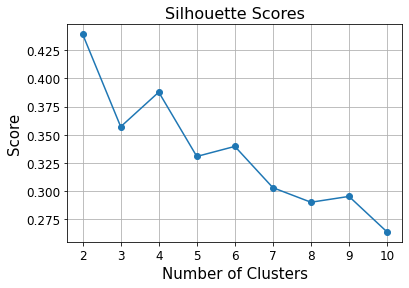

2006
For n_clusters = 2 The average silhouette_score is: 0.367931729074046
For n_clusters = 3 The average silhouette_score is: 0.3725132578687192
For n_clusters = 4 The average silhouette_score is: 0.3787025240397881
For n_clusters = 5 The average silhouette_score is: 0.33570981168500075
For n_clusters = 6 The average silhouette_score is: 0.3462606996959554
For n_clusters = 7 The average silhouette_score is: 0.3280060221587255
For n_clusters = 8 The average silhouette_score is: 0.3100567598994196
For n_clusters = 9 The average silhouette_score is: 0.2907179851044361
For n_clusters = 10 The average silhouette_score is: 0.279462092288067


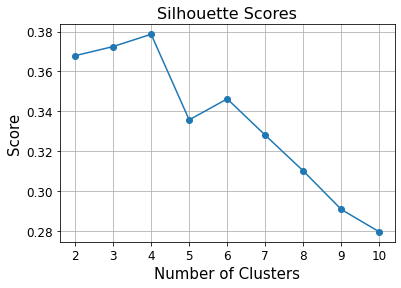

2007
For n_clusters = 2 The average silhouette_score is: 0.41384004172738237
For n_clusters = 3 The average silhouette_score is: 0.3950812862025663
For n_clusters = 4 The average silhouette_score is: 0.3536505917630206
For n_clusters = 5 The average silhouette_score is: 0.36424735300643246
For n_clusters = 6 The average silhouette_score is: 0.33293232616703156
For n_clusters = 7 The average silhouette_score is: 0.2947530483591857
For n_clusters = 8 The average silhouette_score is: 0.3050106945020349
For n_clusters = 9 The average silhouette_score is: 0.2872434554894505
For n_clusters = 10 The average silhouette_score is: 0.27183723931383724


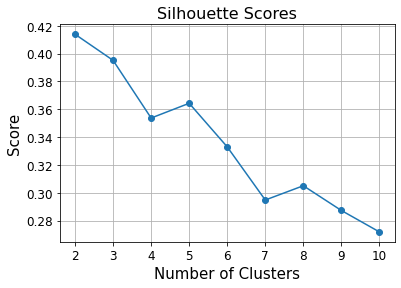

2008
For n_clusters = 2 The average silhouette_score is: 0.4480202182780598
For n_clusters = 3 The average silhouette_score is: 0.3655329017007251
For n_clusters = 4 The average silhouette_score is: 0.39535568949942335
For n_clusters = 5 The average silhouette_score is: 0.3577553368414535
For n_clusters = 6 The average silhouette_score is: 0.34049682419420996
For n_clusters = 7 The average silhouette_score is: 0.33893140969950547
For n_clusters = 8 The average silhouette_score is: 0.2910803558444052
For n_clusters = 9 The average silhouette_score is: 0.29303265209515594
For n_clusters = 10 The average silhouette_score is: 0.29041461095194754


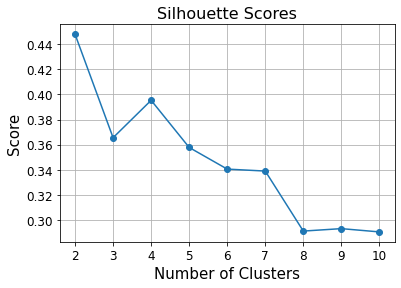

2009
For n_clusters = 2 The average silhouette_score is: 0.3634651782027104
For n_clusters = 3 The average silhouette_score is: 0.325061028512772
For n_clusters = 4 The average silhouette_score is: 0.3747812719232989
For n_clusters = 5 The average silhouette_score is: 0.37083000325716065
For n_clusters = 6 The average silhouette_score is: 0.3533336083295041
For n_clusters = 7 The average silhouette_score is: 0.31410619202896173
For n_clusters = 8 The average silhouette_score is: 0.27641914062138684
For n_clusters = 9 The average silhouette_score is: 0.22176129699839986
For n_clusters = 10 The average silhouette_score is: 0.2348182151852019


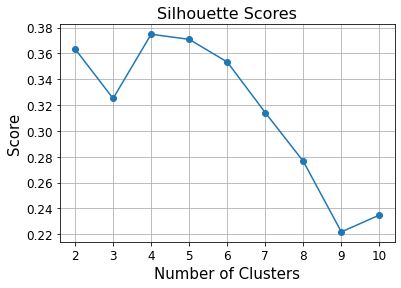

2010
For n_clusters = 2 The average silhouette_score is: 0.3901755895959194
For n_clusters = 3 The average silhouette_score is: 0.3558205530351001
For n_clusters = 4 The average silhouette_score is: 0.3545232325009075
For n_clusters = 5 The average silhouette_score is: 0.3849185328782315
For n_clusters = 6 The average silhouette_score is: 0.3285588234564773
For n_clusters = 7 The average silhouette_score is: 0.3067804753953526
For n_clusters = 8 The average silhouette_score is: 0.29641746824450455
For n_clusters = 9 The average silhouette_score is: 0.2645880558962493
For n_clusters = 10 The average silhouette_score is: 0.259134748032876


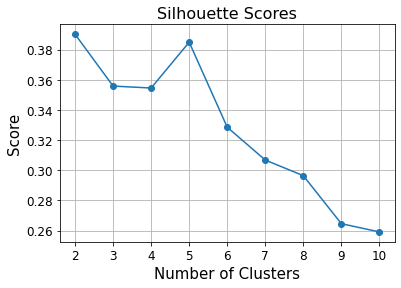

2011
For n_clusters = 2 The average silhouette_score is: 0.2933869354758624
For n_clusters = 3 The average silhouette_score is: 0.39636236498299804
For n_clusters = 4 The average silhouette_score is: 0.3737141212245168
For n_clusters = 5 The average silhouette_score is: 0.3329318694128462
For n_clusters = 6 The average silhouette_score is: 0.34044287402430584
For n_clusters = 7 The average silhouette_score is: 0.31134451518638234
For n_clusters = 8 The average silhouette_score is: 0.29605139578184764
For n_clusters = 9 The average silhouette_score is: 0.29421393353714803
For n_clusters = 10 The average silhouette_score is: 0.28232659082303085


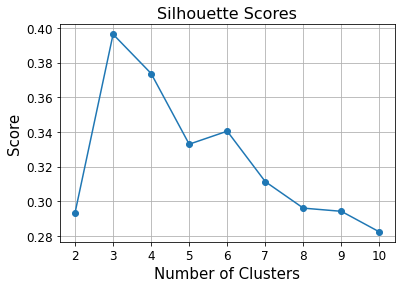

2012
For n_clusters = 2 The average silhouette_score is: 0.3974685978739911
For n_clusters = 3 The average silhouette_score is: 0.35944105999324555
For n_clusters = 4 The average silhouette_score is: 0.31320678631398213
For n_clusters = 5 The average silhouette_score is: 0.30918005431961354
For n_clusters = 6 The average silhouette_score is: 0.3183383598648905
For n_clusters = 7 The average silhouette_score is: 0.2928961890851323
For n_clusters = 8 The average silhouette_score is: 0.2756685624946804
For n_clusters = 9 The average silhouette_score is: 0.25025257702209797
For n_clusters = 10 The average silhouette_score is: 0.26390615716024335


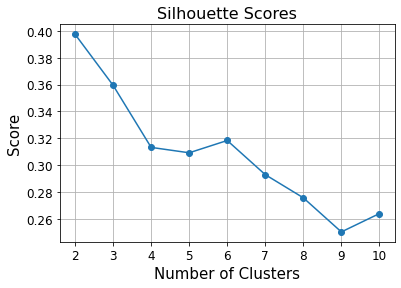

2013
For n_clusters = 2 The average silhouette_score is: 0.4061592865906517
For n_clusters = 3 The average silhouette_score is: 0.3485017229903233
For n_clusters = 4 The average silhouette_score is: 0.3510244475787722
For n_clusters = 5 The average silhouette_score is: 0.32172752383899134
For n_clusters = 6 The average silhouette_score is: 0.3466260682561143
For n_clusters = 7 The average silhouette_score is: 0.308010304045883
For n_clusters = 8 The average silhouette_score is: 0.29584546812240914
For n_clusters = 9 The average silhouette_score is: 0.2961568097299656
For n_clusters = 10 The average silhouette_score is: 0.2655104858068817


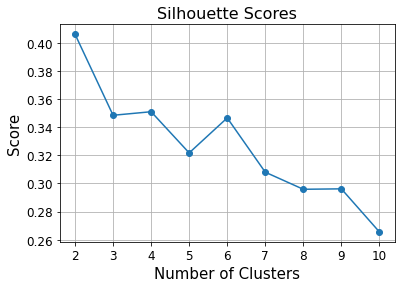

2014
For n_clusters = 2 The average silhouette_score is: 0.4202080196240126
For n_clusters = 3 The average silhouette_score is: 0.36571306081446125
For n_clusters = 4 The average silhouette_score is: 0.36466738031736373
For n_clusters = 5 The average silhouette_score is: 0.33696653302738633
For n_clusters = 6 The average silhouette_score is: 0.3319845999929397
For n_clusters = 7 The average silhouette_score is: 0.3127911201479011
For n_clusters = 8 The average silhouette_score is: 0.29322548057042563
For n_clusters = 9 The average silhouette_score is: 0.26338923040590045
For n_clusters = 10 The average silhouette_score is: 0.24718740380741736


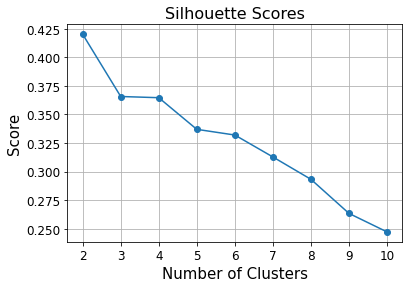

2015
For n_clusters = 2 The average silhouette_score is: 0.38475138387396196
For n_clusters = 3 The average silhouette_score is: 0.36236204796792154
For n_clusters = 4 The average silhouette_score is: 0.35556003765331584
For n_clusters = 5 The average silhouette_score is: 0.35560797702575553
For n_clusters = 6 The average silhouette_score is: 0.30014209899575345
For n_clusters = 7 The average silhouette_score is: 0.3041256995432387
For n_clusters = 8 The average silhouette_score is: 0.294591484145312
For n_clusters = 9 The average silhouette_score is: 0.2826550594095443
For n_clusters = 10 The average silhouette_score is: 0.26782784461619646


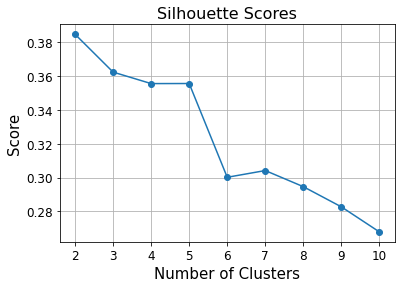

2016
For n_clusters = 2 The average silhouette_score is: 0.3180202511874894
For n_clusters = 3 The average silhouette_score is: 0.3176480191933264
For n_clusters = 4 The average silhouette_score is: 0.352405821012077
For n_clusters = 5 The average silhouette_score is: 0.34781129138880357
For n_clusters = 6 The average silhouette_score is: 0.3400997846059924
For n_clusters = 7 The average silhouette_score is: 0.3223894214730351
For n_clusters = 8 The average silhouette_score is: 0.2911720830845005
For n_clusters = 9 The average silhouette_score is: 0.2730925606026001
For n_clusters = 10 The average silhouette_score is: 0.26439336448283246


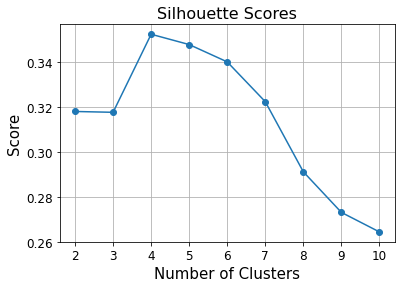

2017
For n_clusters = 2 The average silhouette_score is: 0.3498979809730594
For n_clusters = 3 The average silhouette_score is: 0.321651045494941
For n_clusters = 4 The average silhouette_score is: 0.2979806899187509
For n_clusters = 5 The average silhouette_score is: 0.2858933030963543
For n_clusters = 6 The average silhouette_score is: 0.33078893360871015
For n_clusters = 7 The average silhouette_score is: 0.32453251605621286
For n_clusters = 8 The average silhouette_score is: 0.3069405958115028
For n_clusters = 9 The average silhouette_score is: 0.2843745534891518
For n_clusters = 10 The average silhouette_score is: 0.23966176223386457


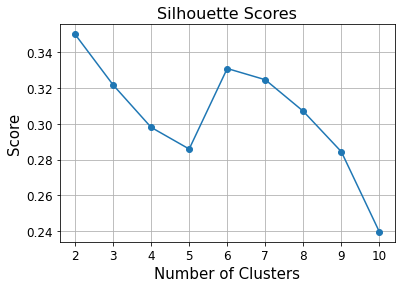

In [25]:
for i in range(2002, 2018):
    print(i)
    season_2010 = season_data(df, i)
    season_2010_numeric = season_numeric_data(season_2010)
    plot_Silh_Score(season_2010_numeric, 2, 11)

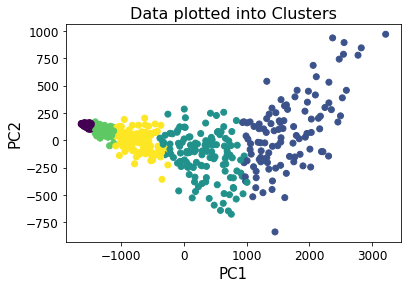

In [82]:
# 2 clusters doesn't really make sense, but 5 performs similarly so we'll use that
spec = generate_spec_model(5)
labels = get_labels(spec, season_2010_numeric)
plot_PCA_with_clusters(labels, season_2010_numeric)

1